# <font style="color:blue">Train a Custom Object Detector using DarkNet YOLOv3</font>
In this notebook, a face mask detector will be trained. It will have two classes: mask and no mask. Darknet framework and YoloV3 architecture will be use. 

# <font style="color:blue">Change Runtime Type</font>
In my particular case, Yolo was run locally. GPU is a RTX 2070, 8GB memory. 

# <font style="color:red"> I will leave the cloning and setup as this is also done in a local linux machine.

# <font style="color:blue">2. Clone the DarkNet Repository </font>
We will use Alexey's darknet fork which has many modifications and improvements and is actively maintained by him.

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

# <font style="color:blue">3. Compile DarkNet</font>
We will first make some changes to the Makefile before we compile. Specifically, we will enable the following:
1. Build darknet with OpenCV
1. Build with CUDA enabled
1. Build with cuDNN enabled.

In [50]:
%cd darknet

/content/drive/My Drive/darknet


In [0]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt

/content/drive/My Drive/darknet
Building. . . It might take 2 minutes
Build completed.


# <font style="color:blue">4. Download Data</font>


Data from kaggle mask-no mask dataset is downloaded.




In [ ]:
!wget "https://www.dropbox.com/s/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip?dl=1" -O mask-data.zip
!unzip mask-data.zip &> /dev/null

Once we have download and unzipped the images, we have to divide into train-test. We do that with the following code.

In [3]:
import random
import os
import subprocess
import sys

image_dir = "/home/pablo/work/opencv-courses/opencv_course_2/week8/project-mask-detector/mask_no-mask/"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg" or f.split(".")[-1] == "jpeg" or f.split(".")[-1] == "png"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

As it was seen in the course, we can use transfer learning in order to start our custom objection detection. Transfer learning basically means using the knowledge of a neural network trained over thousands of different images in order to detect our specific problem. The big advantge of this is that the model does not start from scratch. To this end, we use a pre-trained model which contains convolutional weights trained on ImageNet. We start our model with this base weight. 

In [4]:
# Original File : https://pjreddie.com/media/files/darknet53.conv.74
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

--2021-04-03 17:22:49--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/18dwbfth7prbf0h/darknet53.conv.74 [following]
--2021-04-03 17:22:50--  https://www.dropbox.com/s/dl/18dwbfth7prbf0h/darknet53.conv.74
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3e964122be9f9b1da3bde92082.dl.dropboxusercontent.com/cd/0/get/BL5mySyaFKIAuUkXYm9gwVMKzQtgctKVglR8p2Zs5uluuHkCgMgtN_Qi3X3073m0ROTer1YZtpN_4t0qcXgJjAojFWDRa7DWpHB2XeNX1nImCiBqlrBNXA6y0lqpripPWnqxq_JK-lfb54Y4u3qFrufA/file?dl=1# [following]
--2021-04-03 17:22:50--  https://uc3e964122be9f9b1da3bde92082.dl.dropboxusercontent.com/cd/0/get/BL5mySyaFKIAuUkXYm9gwVMKzQtgctKVglR8p2Zs5uluuHkCgMgtN_Qi3X3073m0ROTer1YZt

# <font style="color:blue">5. Start Training </font>
For starting training using darknet, we need to execute the following command. Here we are specifying the
1. path to the setup file, 
1. path to config file, 
1. path to convolutional weights file 

and also passing some flags such as:

- **`dont_show`** which wont display the graphs. This is required for Colab since it does not have a display and it will crash if it tries to display, not if you run the notebook on your local system.
- **`map`** - this will calculate mAP - mean average precision for the test data which we have specified using the data_test.txt file which contains 20% of our data.

In my case, I do not use the dont_show flag as I can see the plot being updated every time.

It is important to update the config file. While every other variable can be left as it is, there are 2 that need to be changed, namely filter and classes, both in the yolo layer. For classes, one just has to put the number of classes. In our case, classes=2. As for filter, the formula is 3*(5+classes). 

In [6]:
!./darknet detector train  yolov3-mask-setup.data yolov3-mask-train.cfg ./darknet53.conv.74 -dont_show -map 2> train_log.txt

In the attached txt file one can find the training procedure.

# <font style="color:blue">Notes on Training</font>
From the above training process we can make the following observations:
1. The images are resized after every 10 iterations
It takes around 11 seconds per iteration which consists of 64 images for an image size of 576.
1. We can see that the training started very slowly in the first few iterations and then very gradually, the loss started reducing.
1. As we can see the learning rate increases gradually from 0 to 0.001 by the 100th batch ( burn_in was set to 100 ). It would stay there till the 1500th batch when it would again change to 0.0001.
1. mAP is calculated for every 100 iterations. It reaches >80% after 200 iterations.
1. You can check out the training graph for mAP v/s iterations which is saved in the file **chart.png**

# <font style="color:blue">6. Perform Inference</font>
Finally, let us use the trained model to perform inference on some unseen images from the internet.

We have written a simple utility function which can be used to display the input and output similar to what we did in the previous section

We are already familiar with the inference code which we saw in the previous section.

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

### <font style="color:green">6.1. Test Image 1</font>

In [7]:
!wget "https://www.dropbox.com/s/fxei8rit9v2n83s/test-image1.jpg?dl=1" -O test1.jpg

--2021-04-04 11:15:30--  https://www.dropbox.com/s/fxei8rit9v2n83s/test-image1.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/fxei8rit9v2n83s/test-image1.jpg [following]
--2021-04-04 11:15:30--  https://www.dropbox.com/s/dl/fxei8rit9v2n83s/test-image1.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbbe45cee6872ba47696b14c719.dl.dropboxusercontent.com/cd/0/get/BL-XwkuDoMlvPQ59_hKj9qX39q-siyKOEI9Ink39FCRM-Oi4EfRLHcJrIixw0B9JES6J6IfWXUVhs5Y88d4a_ruMXUgSH4xSFvYiNQJZwAmcpwlIL4ZVQq-hTnXg3JuhHMstt8-TJjISfz7srFVN7tFI/file?dl=1# [following]
--2021-04-04 11:15:31--  https://ucbbe45cee6872ba47696b14c719.dl.dropboxusercontent.com/cd/0/get/BL-XwkuDoMlvPQ59_hKj9qX39q-siyKOEI9Ink39FCRM-Oi4EfRLHcJrIixw0B9JES6J6IfWXUVhs5Y

 CUDNN_HALF=1 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 211 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test1.jpg: Predicted in 312.340000 milli-seconds.
Mask: 100%


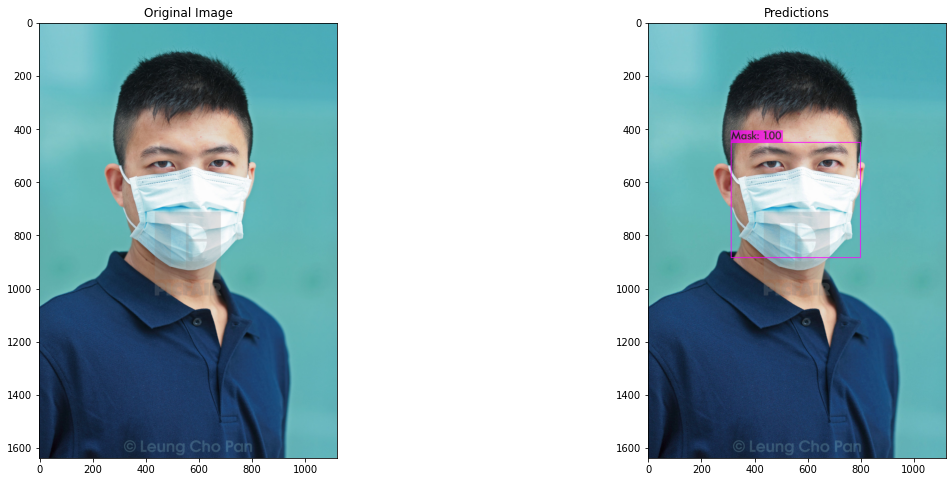

In [4]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/mask_yolov3/yolov3-mask-train_best.weights test1.jpg -thresh .6 2> /dev/null
display_output("test1.jpg")

### <font style="color:green">6.2. Test Image 2</font>

In [9]:
!wget https://www.dropbox.com/s/ia1fijzr69ytpp1/test-image2.jpg?dl=1 -O test2.jpg

--2021-04-04 11:16:28--  https://www.dropbox.com/s/ia1fijzr69ytpp1/test-image2.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ia1fijzr69ytpp1/test-image2.jpg [following]
--2021-04-04 11:16:29--  https://www.dropbox.com/s/dl/ia1fijzr69ytpp1/test-image2.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdcbcc99d9a5aa7d5e331d03f96.dl.dropboxusercontent.com/cd/0/get/BL95Wjv2r2friybtrPNt4ToQ8TxbDswRRu3WTLAvwH18Tr2rJCWmVtzpib8j_GdM0pQhuaYRtQrJBdDpYyj-LlWPAPiZcZimGPCnizctFao1mxcC39Y9-j09-SO_iLui8W-su3d9KZnx3YWsiGkn_MWs/file?dl=1# [following]
--2021-04-04 11:16:29--  https://ucdcbcc99d9a5aa7d5e331d03f96.dl.dropboxusercontent.com/cd/0/get/BL95Wjv2r2friybtrPNt4ToQ8TxbDswRRu3WTLAvwH18Tr2rJCWmVtzpib8j_GdM0pQhuaYRtQrJBdD

 CUDNN_HALF=1 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 211 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test2.jpg: Predicted in 304.421000 milli-seconds.
Mask: 100%
Mask: 98%
Mask: 96%
No-mask: 100%
Mask: 99%


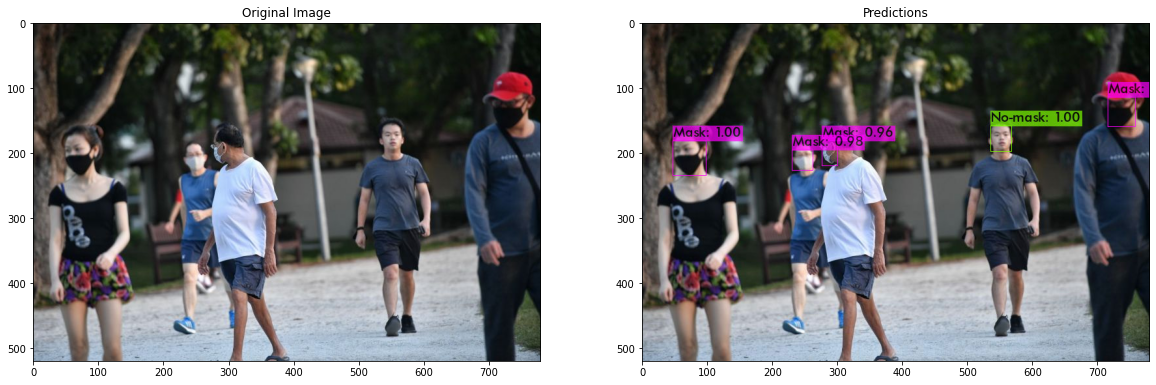

In [5]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/mask_yolov3/yolov3-mask-train_best.weights test2.jpg -thresh .6 2> /dev/null
display_output("test2.jpg")

### <font style="color:green">6.3. Test Image 3</font>

In [11]:
!wget https://www.dropbox.com/s/g905k4r1git5kbx/test-image3.jpg?dl=1 -O test3.jpg

--2021-04-04 11:18:56--  https://www.dropbox.com/s/g905k4r1git5kbx/test-image3.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/g905k4r1git5kbx/test-image3.jpg [following]
--2021-04-04 11:18:57--  https://www.dropbox.com/s/dl/g905k4r1git5kbx/test-image3.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc56535a59b11d1569624c8770b5.dl.dropboxusercontent.com/cd/0/get/BL-0dq4FeUx1PkneDs8xcCNP46QxZRj4Wb7pI8zp8sFetR8x5rK9zug0nt55-MzggXbYYRDpcWWiDZbrNTZZDwEyDPib_cM7RvwFXVhcX2RACrLqB85uc217csOyGRjyjQGpEM9z47j36Q3z4a_utD3F/file?dl=1# [following]
--2021-04-04 11:18:57--  https://uc56535a59b11d1569624c8770b5.dl.dropboxusercontent.com/cd/0/get/BL-0dq4FeUx1PkneDs8xcCNP46QxZRj4Wb7pI8zp8sFetR8x5rK9zug0nt55-MzggXbYYRDpcWWiDZb

 CUDNN_HALF=1 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 211 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test3.jpg: Predicted in 305.642000 milli-seconds.
Mask: 100%
Mask: 99%
Mask: 100%
No-mask: 99%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 99%
Mask: 100%
Mask: 100%


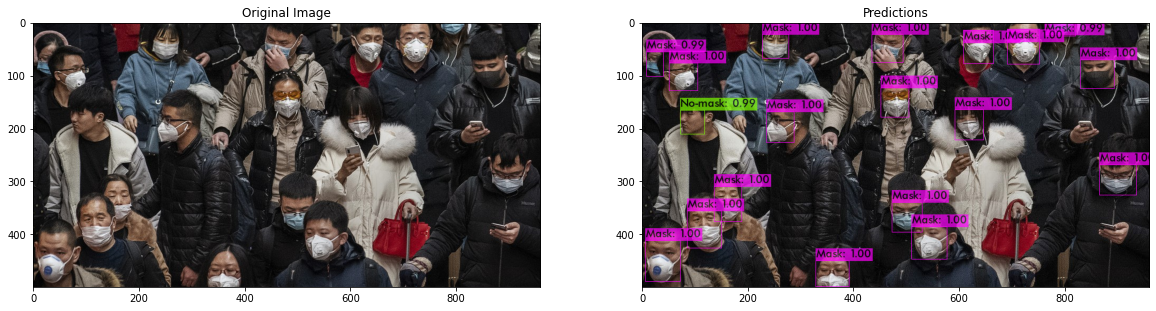

In [6]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/mask_yolov3/yolov3-mask-train_best.weights test3.jpg -thresh .6 2> /dev/null
display_output("test3.jpg")

### <font style="color:green">6.4. Test Image 4</font>

In [13]:
!wget https://www.dropbox.com/s/90ggmiur7b8g35m/test-image4.jpg?dl=1 -O test4.jpg

--2021-04-04 11:20:12--  https://www.dropbox.com/s/90ggmiur7b8g35m/test-image4.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/90ggmiur7b8g35m/test-image4.jpg [following]
--2021-04-04 11:20:13--  https://www.dropbox.com/s/dl/90ggmiur7b8g35m/test-image4.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca0e49ffc59f5dad98b2571c5e0.dl.dropboxusercontent.com/cd/0/get/BL8CYl8gFIQWBHz9i5kR5KZ1pKmTtmre8bEslocr2f1zzmH5wFE4OhVCEL5apmT29ShNLAhaV75HyMvbTjvNihYs8M4x0ue7tjzzQG1dqK2H1-AZ7VIlIPAY-Mdb4-AAmi4Lp44vLAwSTgbygzLSCR_n/file?dl=1# [following]
--2021-04-04 11:20:13--  https://uca0e49ffc59f5dad98b2571c5e0.dl.dropboxusercontent.com/cd/0/get/BL8CYl8gFIQWBHz9i5kR5KZ1pKmTtmre8bEslocr2f1zzmH5wFE4OhVCEL5apmT29ShNLAhaV75HyMv

 CUDNN_HALF=1 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 211 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test4.jpg: Predicted in 313.245000 milli-seconds.
No-mask: 98%
No-mask: 70%
Mask: 100%
Mask: 100%
No-mask: 98%
Mask: 100%
Mask: 73%
Mask: 100%


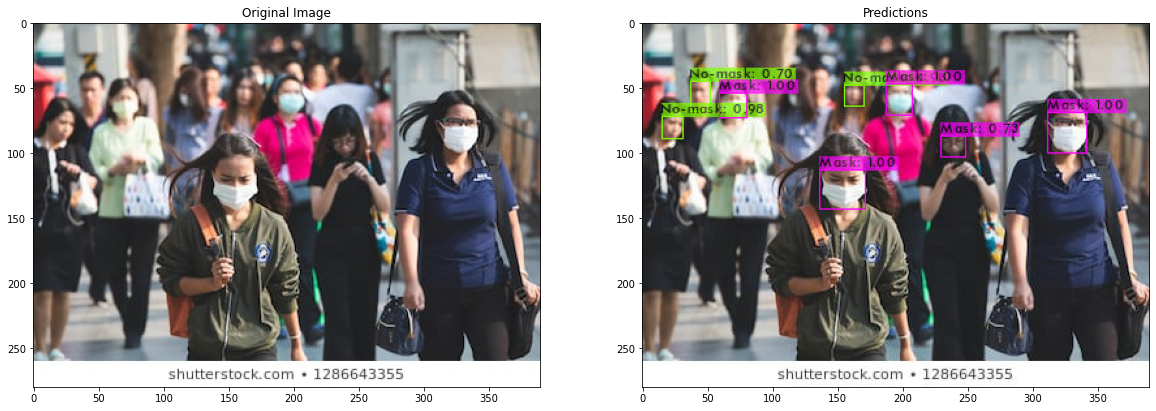

In [10]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/mask_yolov3/yolov3-mask-train_best.weights test4.jpg -thresh .6 2> /dev/null
display_output("test4.jpg")

### <font style="color:green">6.5. Test Video 1</font>

In [17]:
!wget https://www.dropbox.com/s/pds0w3z5y7w89oz/test-video1.mp4?dl=1 -O test-video1.mp4


--2021-04-04 11:25:23--  https://www.dropbox.com/s/pds0w3z5y7w89oz/test-video1.mp4?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/pds0w3z5y7w89oz/test-video1.mp4 [following]
--2021-04-04 11:25:24--  https://www.dropbox.com/s/dl/pds0w3z5y7w89oz/test-video1.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb75633892e2cdee516413f8aae.dl.dropboxusercontent.com/cd/0/get/BL_hiO8YDmlGdOIVRi-2cgH6j6EFZmVb_YJGi2ZK0CpsAVLoD9xri49LkDWITS1j6q52Zwwz_7JIny7nLJJKNQu8blLicIHr_uqr-1zTXec6kp1yn0ti1oSGmUBipjDscVp5GbphUMjeRskoTddD7sIb/file?dl=1# [following]
--2021-04-04 11:25:24--  https://ucb75633892e2cdee516413f8aae.dl.dropboxusercontent.com/cd/0/get/BL_hiO8YDmlGdOIVRi-2cgH6j6EFZmVb_YJGi2ZK0CpsAVLoD9xri49LkDWITS1j6q52Zwwz_7JIny7

In [13]:
!./darknet detector demo yolov3-mask-setup.data yolov3-mask-test.cfg backup/mask_yolov3/yolov3-mask-train_best.weights test-video1.mp4 -thresh .7 -out_filename out-vid1.avi -dont_show 2> /dev/null

 CUDNN_HALF=1 
Demo
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 211 K-images (3 Kilo-batches_64) 
video file: test-video1.mp4
Video stream: 1600 x 842 
Objects:


FPS:0.0 	 AVG_FPS:0.0
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
No-mask: 71% 
Mask: 99% 

FPS:3.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
Mask: 99% 

FPS:6.1 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
Mask: 99% 

FPS:8.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
Mask: 99% 

FPS:11.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
Mask: 100% 

FPS:14.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
Mask: 99% 

FPS:17.3 	 A

Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:38.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.4 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.4 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:



Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.1 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.1 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.0 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.0 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.1 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.3 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.2 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.4 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.2 	 AVG_FPS:39.3

 cvWriteFrame 
O

Objects:

No-mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:38.9 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

No-mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:38.8 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

No-mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:38.9 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

No-mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:38.8 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

No-mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:38.7 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

No-mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:38.5 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

No-mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:38.6 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

No-mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:38.6 	 AVG_FPS:39.3

 cvWriteFrame 
Objects:

No-mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:38.5 	 AVG_F


 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.4 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.5 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.7 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.7 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.9 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.0 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.1 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.1 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.8 	 AVG_FPS:39.5



Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:40.0 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:40.1 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:40.1 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:40.3 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:40.3 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:39.8 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:39.9 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.0 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:40.1 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:


Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.8 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.8 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.9 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.9 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.8 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:40.0 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.9 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.9 	 AVG_FPS:39.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:39.8 	 AVG_FPS:39.5

 cvWriteFrame 
O

In [19]:
!wget https://www.dropbox.com/s/sqwu0ktdtlxtdsd/test-video2.mp4?dl=1 -O test-video2.mp4

--2021-04-04 11:28:23--  https://www.dropbox.com/s/sqwu0ktdtlxtdsd/test-video2.mp4?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/sqwu0ktdtlxtdsd/test-video2.mp4 [following]
--2021-04-04 11:28:23--  https://www.dropbox.com/s/dl/sqwu0ktdtlxtdsd/test-video2.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc810c037496bb3092ad5f41bc7a.dl.dropboxusercontent.com/cd/0/get/BL-w79fU1xy662VcsCnjbtb_t0tOtAqi-V6AzokAEzLpMNKwEFjUFHTXk2ExH_R0D_TKxZi3PUhRFoqzXZ_dyt-xe0Z4ZAdNcLvS5pX4uUqU11p8dK-KzyaDeSzcBmEY8x2lPUEPjIpncgEkJr0US9NL/file?dl=1# [following]
--2021-04-04 11:28:24--  https://uc810c037496bb3092ad5f41bc7a.dl.dropboxusercontent.com/cd/0/get/BL-w79fU1xy662VcsCnjbtb_t0tOtAqi-V6AzokAEzLpMNKwEFjUFHTXk2ExH_R0D_TKxZi3PUhRFoq

In [21]:
!./darknet detector demo yolov3-mask-setup.data yolov3-mask-test.cfg backup/mask_yolov3/yolov3-mask-train_best.weights test-video2.mp4 -thresh .4 -out_filename out-vid2.avi -dont_show 2> /dev/null

 CUDNN_HALF=1 
Demo
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 211 K-images (3 Kilo-batches_64) 
video file: test-video2.mp4
Video stream: 1280 x 718 
Objects:


FPS:0.0 	 AVG_FPS:0.0
Objects:

No-mask: 93% 
No-mask: 70% 
No-mask: 47% 
No-mask: 46% 
Mask: 97% 

FPS:3.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 95% 
No-mask: 94% 
No-mask: 63% 
Mask: 99% 

FPS:6.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 88% 
No-mask: 80% 
No-mask: 55% 
Mask: 97% 

FPS:9.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 96% 
No-mask: 45% 
No-mask: 42% 
No-mask: 42% 
Mask: 97% 

FPS:12.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 98% 
No-mask: 53% 
No-mask: 48% 
Mask: 96% 

FPS:14.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 98% 
No-mask: 58% 
No-mask: 46% 
Mask: 96% 

FPS:16.5 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 49% 
Mask: 98% 

FPS:19.1 	 AVG_FPS


 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
Mask: 60% 
Mask: 48% 

FPS:42.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
Mask: 87% 

FPS:42.5 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
Mask: 78% 

FPS:42.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
Mask: 81% 

FPS:42.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 78% 
Mask: 51% , No-mask: 41% 
Mask: 83% 

FPS:42.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
Mask: 92% 
Mask: 90% 

FPS:43.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
Mask: 92% 
Mask: 90% 

FPS:43.1 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 54% 
Mask: 94% 
Mask: 88% 

FPS:43.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 82% 
Mask: 86% 
Mask: 78% 

FPS:43.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No


 cvWriteFrame 
Objects:

No-mask: 98% 
No-mask: 64% 
Mask: 100% 

FPS:43.8 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 98% 
No-mask: 71% 
Mask: 100% 

FPS:43.8 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 98% 
Mask: 100% 

FPS:43.9 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 98% 
No-mask: 83% 
Mask: 100% 

FPS:44.0 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 97% 
Mask: 100% 

FPS:44.0 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 99% 
No-mask: 50% 
Mask: 100% 

FPS:44.1 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 97% 
No-mask: 93% 
Mask: 100% 

FPS:43.9 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 97% 
No-mask: 94% 
Mask: 100% 

FPS:43.7 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 44% 
Mask: 100% 

FPS:43.7 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 72% 
Mask: 100% 

FPS:43.7 	 AVG_FPS:42.1

 cvWriteFrame 


Objects:

No-mask: 100% 
No-mask: 98% 
No-mask: 71% 
Mask: 100% 
Mask: 81% 
Mask: 69% 

FPS:43.7 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 86% 
Mask: 100% 
Mask: 72% 
Mask: 64% 

FPS:43.9 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 78% 
Mask: 100% 
Mask: 91% 
Mask: 90% 

FPS:43.7 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 85% 
Mask: 100% 
Mask: 91% 
Mask: 90% 

FPS:43.6 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 75% 
Mask: 100% 
Mask: 98% 
Mask: 98% 
Mask: 88% 

FPS:43.6 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 98% 
No-mask: 69% 
Mask: 100% 
Mask: 95% 
Mask: 86% 

FPS:43.7 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 49% 
No-mask: 41% 
Mask: 100% 
Mask: 96% 
Mask: 87% 

FPS:43.7 	 AVG_FPS:42.1

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 98% 
No-mask: 67% 
Mask: 100% 
Mask: 98% 
Mask: 94% 

FPS:43.8 	 AVG_FPS:42.1

 cvWriteFrame 
Object

Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 93% 
No-mask: 91% 
No-mask: 47% 
No-mask: 45% 
Mask: 99% 

FPS:44.0 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 97% 
No-mask: 96% 
No-mask: 88% 
No-mask: 47% 
Mask: 100% 

FPS:43.9 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 92% 
No-mask: 85% 
No-mask: 78% 
No-mask: 46% 
Mask: 99% 

FPS:44.0 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 62% 
Mask: 44% 

FPS:43.9 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 86% 
No-mask: 60% 

FPS:44.0 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 86% 
No-mask: 69% 

FPS:44.1 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 87% 
No-mask: 59% 
Mask: 77% 

FPS:44.1 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 85% 
No-mask: 64% 

FPS:44.1 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 98% 
No-mask: 65% 

FPS:44.0 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-m


 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 98% 
No-mask: 97% 
No-mask: 84% 
No-mask: 44% 

FPS:44.1 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 98% 
No-mask: 98% 
No-mask: 82% 
No-mask: 50% 

FPS:43.9 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 61% 
No-mask: 57% 
No-mask: 55% 

FPS:43.9 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 98% 
No-mask: 48% 
No-mask: 45% 
Mask: 73% 

FPS:43.8 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 96% 
No-mask: 62% 
No-mask: 61% 
No-mask: 48% 
Mask: 86% 

FPS:43.9 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 96% 
Mask: 97% 

FPS:44.0 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 98% 
No-mask: 62% 
No-mask: 44% 
Mask: 97% 

FPS:44.0 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 98% 
No-mask: 55% 
No-mask: 44% 
Mask: 97% 

FPS:44.0 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 99%

Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 87% 
No-mask: 47% 
Mask: 99% 

FPS:43.1 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 98% 
No-mask: 91% 
No-mask: 52% 
Mask: 99% 

FPS:43.2 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 97% 
No-mask: 78% 
Mask: 100% 

FPS:43.2 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 99% 
No-mask: 82% 
Mask: 100% 

FPS:43.2 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 97% 
No-mask: 83% 
No-mask: 65% 
No-mask: 55% 
Mask: 100% 

FPS:43.1 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 98% 
No-mask: 97% 
No-mask: 82% 
No-mask: 66% 
No-mask: 51% 
Mask: 100% 

FPS:43.4 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 97% 
No-mask: 92% 
No-mask: 61% 
No-mask: 58% 
Mask: 100% 

FPS:43.3 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 98% 
No-mask: 94% 
No-mask: 87% 
Mask: 99% 

FPS:43.4 	 AVG_FPS:43.9

 cvWriteFrame 
Objects:

No-mask: 9

Objects:

No-mask: 44% 
Mask: 100% 
Mask: 88% 

FPS:43.7 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 86% 

FPS:43.8 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 84% 

FPS:43.7 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

Mask: 100% 

FPS:43.7 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

Mask: 98% 

FPS:43.6 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 51% 
Mask: 99% 

FPS:43.6 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 68% 
Mask: 99% 

FPS:43.6 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 90% 
No-mask: 54% 
Mask: 100% 

FPS:43.5 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 90% 
No-mask: 54% 
Mask: 100% 

FPS:43.5 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 93% 
No-mask: 44% 
Mask: 99% 

FPS:43.6 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 97% 
No-mask: 94% 
No-mask: 47% 
Mask: 99% 

FPS:43.8 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 96% 
No-mask: 95% 
No-mask: 62% 

FPS:43.6 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask:


 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 98% 
No-mask: 95% 
No-mask: 69% 

FPS:43.7 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 96% 
No-mask: 95% 
No-mask: 84% 

FPS:43.5 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 96% 
No-mask: 92% 
No-mask: 84% 

FPS:43.6 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 99% 
No-mask: 96% 
No-mask: 90% 

FPS:43.6 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 99% 
No-mask: 98% 
No-mask: 87% 

FPS:43.7 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 100% 
No-mask: 99% 
No-mask: 90% 

FPS:43.7 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 98% 
No-mask: 98% 
No-mask: 97% 
No-mask: 46% 

FPS:43.6 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 96% 
No-mask: 96% 
No-mask: 89% 
No-mask: 88% 
No-mask: 71% 
No-mask: 40% 

FPS:43.7 	 AVG_F


 cvWriteFrame 
Objects:

No-mask: 95% 
No-mask: 94% 
No-mask: 82% 
No-mask: 66% 
No-mask: 44% 
Mask: 100% 

FPS:43.7 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 95% 
No-mask: 94% 
No-mask: 63% 
No-mask: 62% 
Mask: 100% 

FPS:43.5 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 97% 
No-mask: 94% 
No-mask: 71% 
No-mask: 61% 
Mask: 100% 

FPS:43.6 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 96% 
No-mask: 79% 
No-mask: 64% 
No-mask: 59% 
Mask: 100% 

FPS:43.6 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 86% 
No-mask: 69% 
No-mask: 47% 
Mask: 100% 

FPS:43.5 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
Mask: 100% 

FPS:43.6 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 96% 
No-mask: 60% 
Mask: 100% 

FPS:43.7 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 99% 
Mask: 100% 

FPS:43.8 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 99% 
Mask: 100% 

FPS:43.7 	 AVG_FPS:

Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 94% 
No-mask: 89% 
No-mask: 73% 
No-mask: 56% 
No-mask: 42% 
Mask: 84% 
Mask: 68% 

FPS:43.5 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 96% 
No-mask: 96% 
No-mask: 70% 
Mask: 98% 
Mask: 96% 

FPS:43.5 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 99% 
No-mask: 93% 
No-mask: 92% 
No-mask: 76% 
Mask: 99% 
Mask: 95% 

FPS:43.7 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 98% 
No-mask: 96% 
No-mask: 87% 
No-mask: 57% 
No-mask: 46% 
Mask: 87% 
Mask: 82% 

FPS:43.9 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 99% 
No-mask: 98% 
No-mask: 92% 
No-mask: 83% 
No-mask: 56% 
No-mask: 40% 
Mask: 73% 

FPS:43.7 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 97% 
No-mask: 97% 
No-mask: 95% 
No-mask: 84% 
No-mask: 44% 
Mask: 92% 

FPS:43.8 	 AVG_FPS:43.5

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-ma


 cvWriteFrame 
Objects:

No-mask: 84% 
No-mask: 83% 
No-mask: 63% 
No-mask: 41% 
Mask: 96% 
Mask: 95% 
Mask: 82% 

FPS:43.6 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 91% 
No-mask: 78% 
No-mask: 76% 
Mask: 99% 
Mask: 99% 
Mask: 88% 

FPS:43.6 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 87% 
No-mask: 77% 
No-mask: 67% 
Mask: 99% 
Mask: 96% 
Mask: 91% 

FPS:43.7 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 91% 
No-mask: 85% 
No-mask: 78% 
No-mask: 57% 
Mask: 98% 
Mask: 96% 

FPS:43.7 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 78% 
No-mask: 74% 
No-mask: 73% 
Mask: 96% 
Mask: 92% 
Mask: 91% 

FPS:43.8 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 76% 
No-mask: 76% 
No-mask: 74% 
No-mask: 41% 
Mask: 96% 
Mask: 91% 
Mask: 91% 

FPS:43.8 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 87% 
No-mask: 85% 
No-mask: 63% 
Mask: 99% 
Mask: 50% 

FPS:43.6 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 87% 
No-mask: 58% 
No-mask: 52% 
Mask: 99% 
Mask: 98% 

FPS:43.

Objects:

No-mask: 100% 
No-mask: 66% 
No-mask: 61% 
No-mask: 49% 
No-mask: 41% 

FPS:43.6 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 77% 
No-mask: 62% 
No-mask: 59% 
No-mask: 54% 

FPS:43.7 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 74% 
No-mask: 65% 
No-mask: 52% 
No-mask: 42% 

FPS:43.7 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 85% 
No-mask: 81% 
No-mask: 55% 

FPS:43.8 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 83% 
No-mask: 81% 
No-mask: 64% 

FPS:43.8 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 87% 
No-mask: 87% 
No-mask: 85% 

FPS:43.9 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 94% 
No-mask: 76% 
No-mask: 63% 
No-mask: 40% 

FPS:43.8 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 94% 
No-mask: 93% 
No-mask: 82% 
No-mask: 43% 
Mask: 89% 

FPS:44.0 	 AVG_FPS:43.8

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 98% 
No-mask: 82% 
No


 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 99% 
No-mask: 85% 
No-mask: 75% 
Mask: 100% 

FPS:44.1 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 91% 
No-mask: 84% 
No-mask: 44% 
Mask: 100% 

FPS:43.9 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 83% 
No-mask: 64% 
Mask: 100% 

FPS:43.9 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 83% 
No-mask: 61% 
Mask: 100% 

FPS:43.7 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 97% 
No-mask: 95% 
No-mask: 78% 
Mask: 100% 

FPS:43.8 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 87% 
No-mask: 85% 
No-mask: 52% 
Mask: 100% 

FPS:43.8 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 79% 
No-mask: 67% 
No-mask: 59% 
Mask: 100% 

FPS:43.6 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 83% 
No-mask: 58% 
Mask: 100% 

FPS:43.6 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 97% 

Objects:

No-mask: 100% 
No-mask: 98% 
No-mask: 93% 
No-mask: 92% 
Mask: 100% 
Mask: 96% 

FPS:43.5 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 98% 
No-mask: 91% 
Mask: 100% 
Mask: 83% 

FPS:43.7 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 99% 
No-mask: 66% 
Mask: 100% 
Mask: 83% 

FPS:43.5 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 97% 
No-mask: 45% 
No-mask: 44% 
Mask: 100% 
Mask: 77% 

FPS:43.6 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 98% 
No-mask: 98% 
No-mask: 73% 
Mask: 100% 

FPS:43.5 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 99% 
No-mask: 98% 
No-mask: 67% 
Mask: 100% 

FPS:43.5 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 97% 
No-mask: 91% 
No-mask: 40% 
Mask: 100% 

FPS:43.4 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 93% 
No-m

Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 96% 
No-mask: 84% 

FPS:43.9 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 96% 
No-mask: 88% 

FPS:43.9 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 94% 
No-mask: 86% 
No-mask: 76% 

FPS:44.0 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 82% 
No-mask: 44% 

FPS:44.0 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 57% 
No-mask: 51% 

FPS:43.8 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 72% 

FPS:43.8 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 93% 
No-mask: 64% 

FPS:43.9 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 94% 
No-mask: 63% 

FPS:43.9 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
No-mask: 99% 

FPS:43.9 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100

Objects:

No-mask: 100% 
No-mask: 88% 
No-mask: 87% 
No-mask: 60% 
Mask: 73% 

FPS:43.7 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 88% 
No-mask: 87% 
No-mask: 59% 
Mask: 74% 

FPS:43.9 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 61% 
No-mask: 60% 
No-mask: 53% 
Mask: 65% 
Mask: 46% 

FPS:43.8 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 64% 
No-mask: 61% 
No-mask: 59% 
No-mask: 45% 
Mask: 47% 

FPS:43.9 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 90% 
No-mask: 60% 
Mask: 87% 

FPS:44.0 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 90% 
No-mask: 75% 
Mask: 63% 
Mask: 59% 

FPS:44.0 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 67% 

FPS:44.0 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 68% 
Mask: 46% 

FPS:43.8 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 53% 
Mask: 73% 

FPS:44.0 	 AVG_FPS:43.6

 cvWriteFrame 
Objects:

No-mas

Objects:

No-mask: 95% 
No-mask: 71% 
No-mask: 52% 
Mask: 96% 

FPS:41.8 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 64% 
No-mask: 56% 

FPS:41.9 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 63% 
No-mask: 59% 

FPS:42.1 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 92% 
No-mask: 63% 

FPS:42.3 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 88% 
No-mask: 50% 

FPS:42.4 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 98% 
No-mask: 98% 
No-mask: 59% 

FPS:42.6 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 95% 
No-mask: 60% 

FPS:42.6 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 97% 
No-mask: 90% 
No-mask: 85% 
No-mask: 72% 
No-mask: 68% 
No-mask: 52% 

FPS:42.8 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 97% 
No-mask: 90% 
No-mask: 85% 
No-mask: 72% 
No-mask: 68% 
No-mask: 52% 

FPS:42.6 	 AVG_FPS:43.7

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 97% 
No-mask: 68% 
No-mask: 46% 

FPS:42.6 	 AVG_FPS:43.7

 cvWriteFrame 
Ob